# Toy Example of SBI in Population Genetics

Based on the knowledge about `sbi` and simulating population using `msprime`, in this notebook we will apply simulation‑based inference to infer **two** effective population sizes `Ne_1` and `Ne_2` from the number of segregating sites observed in simulated DNA sequences in a very simple setup. 

Other parameters, such as recombination rate, mutation rate, and so on, are fixed. 

Although real applications would use more sophisticated summary statistics, this toy example demonstrates the whole workflow.

In [453]:
import torch
from sbi.inference import NPE
from sbi.utils import BoxUniform
import msprime
import numpy as np
import matplotlib.pyplot as plt
from sbi.analysis import pairplot
from sbi.diagnostics import run_sbc,check_sbc
from sbi.analysis.plot import sbc_rank_plot
from sbi.analysis import plot_summary


## Simulation model
We assume a single population evolving under the neutral coalescent. Chromosomes are simulated with length 1 Mb, a fixed mutation rate and recombination rate. 

The simulator function will take $\theta$, including $N_{e1}$, and $N_{e2}$, as input and return the folded AFS as a summary statistic. Each of the `Ne` is drawn from a uniform distribution. (This is not a realistic scenario!) 
> Note that when simulating populations using `msprime`, the time of effective population size changes should be defined as well. In this case, we simply say that the change happens 100 generations ago.

Again, we use `msprime` to simulate the tree sequence, and extract the folded AFS using the `tskit` function.

In [431]:
def simulator(theta):
    """
    input: theta: tensor of shape (num_simulations, num_parameters)
    output: s_stats: tensor of shape (num_simulations, num_summary_statistics)
    """
    s_stats = []
    for ne in theta.tolist():
        ts = simulate_constant_population(sequence_length=1e6, ne=ne, samples=10, recomb_rate=1e-9, mutation_rate=1e-7)
        s = ts.allele_frequency_spectrum()
        s_stats.append([s])
    return torch.tensor(s_stats, dtype=torch.float32)

def simulate_constant_population(sequence_length, ne, samples, recomb_rate, mutation_rate):
    # Define demography
    demography = msprime.Demography()
    demography.add_population(initial_size=ne[0])
    for i in range(1, len(ne)):
                demography.add_population_parameters_change(
                    initial_size=ne[i], time=i * 100
                )

    # Simulate ancestry and mutations
    ts_anc = msprime.sim_ancestry(samples=samples,
                                recombination_rate=recomb_rate,
                                sequence_length=sequence_length,
                                demography=demography)
    ts = msprime.sim_mutations(ts_anc, rate=mutation_rate)

    return ts


We draw each `Ne` from the range of 10 to 1e5 under an uniform distribution.

In [457]:
# Prior distribution for Ne. 
num_Ne = 2
prior = BoxUniform(low=10*torch.ones(num_Ne), high=1e5*torch.ones(num_Ne))

# Generate training data
num_simulations = 200
theta = prior.sample((num_simulations,))

In [458]:
x = simulator(theta)

In [459]:
# Train NPE
inference = NPE(prior=prior)
inference = inference.append_simulations(theta, x.squeeze())
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 94 epochs.

After the network got trained, we want to investigate the results. We can sample again from the prior to get an independent test dataset.

In [460]:
test_theta = prior.sample((1,)) 
x_o = simulator(test_theta).squeeze()
samples = posterior.sample((10000,), x=x_o)

  0%|          | 0/10000 [00:00<?, ?it/s]

For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/Users/yuxinning/Projects/sbi_workshop_Legend2025/notebooks/sbi-logs/NPE_C/2025-11-28T16_31_00.828687' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


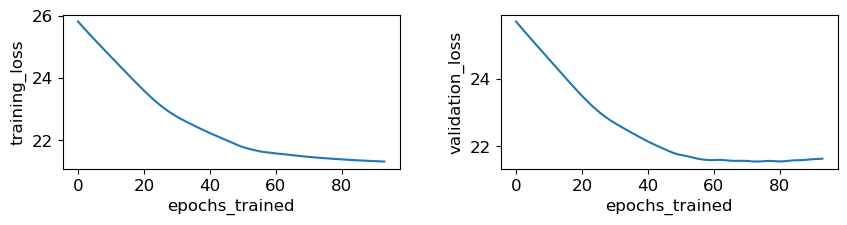

In [461]:
from sbi.analysis import plot_summary

_ = plot_summary(
    inference,
    tags=["training_loss", "validation_loss"],
    figsize=(10, 2),
)

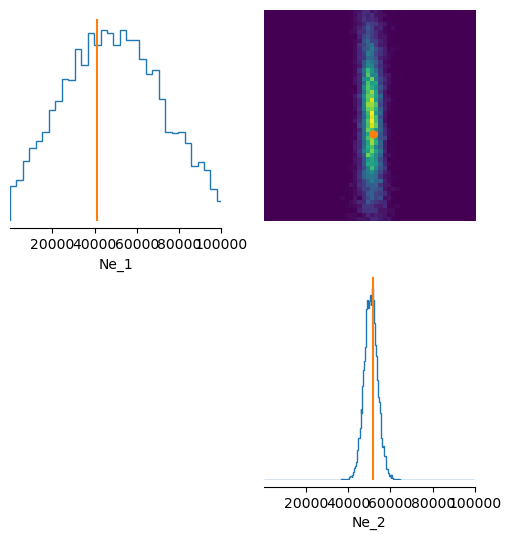

In [462]:
limit = [[10, 1e5]] * num_Ne
labels = [f"Ne_{i+1}" for i in range(num_Ne)]
_ = pairplot(
    samples,
    points=test_theta,
    limits=limit,
    figsize=(6, 6),
    labels=labels,
)

### Posterior predictive checks

In [463]:
posterior_samples = posterior.sample((10,), x=x_o)
posterior_predictives = simulator(posterior_samples)

  0%|          | 0/10 [00:00<?, ?it/s]

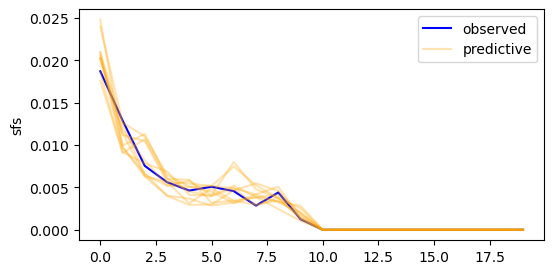

In [464]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
_ = ax.plot(x_o[1:], c='blue')
for i in range(10): 
    _ = ax.plot(posterior_predictives[i].squeeze()[1:], alpha=0.3, c='orange')
_ = ax.legend(["observed", "predictive"])
_ = ax.set_ylabel("sfs")
_ = plt.show()

## Simulation-Based Calibration

In [466]:
num_sbc_runs = 100  # choose a number of sbc runs, should be ~100s
theta_o_i = prior.sample((num_sbc_runs,))
x_o_i = simulator(theta_o_i)

In [470]:
num_posterior_samples = 1000
ranks, dap_samples = run_sbc(
    theta_o_i,
    x_o_i,
    posterior,
    num_posterior_samples=num_posterior_samples,
    use_batched_sampling=False,  # `True` can give speed-ups, but can cause memory issues.
)

Sampling 100 times (1000,) posterior samples.: 100%|██████████| 100/100 [00:02<00:00, 36.64it/s]


Calculating ranks for 100 SBC samples:   0%|          | 0/100 [00:00<?, ?it/s]

One check provided by the `sbi` package is shown below. The `check_stats` variable contains a dictionary with 3 metrics that help to judge our posterior. The “first” two compare the ranks to a uniform distribution. 

You can find more about [KS test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test#Two-sample_Kolmogorov–Smirnov_test) and [c2st test](https://arxiv.org/abs/1610.06545).

In [471]:
check_stats = check_sbc(ranks, theta_o_i, dap_samples, 1_000)
print(check_stats)

{'ks_pvals': tensor([0.0066, 0.6004]), 'c2st_ranks': tensor([0.5200, 0.5350], dtype=torch.float64), 'c2st_dap': tensor([0.5600, 0.4650], dtype=torch.float64)}


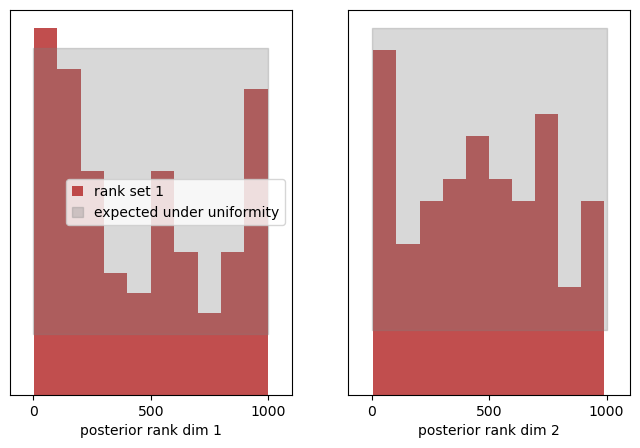

In [473]:
fig, ax = sbc_rank_plot(
    ranks,
    num_posterior_samples,
    plot_type="hist",
    num_bins=10
)